# 01 - Autograd: automatic differentiation 
 - Original notebook: https://github.com/Atcold/pytorch-Deep-Learning/blob/master/03-autograd_tutorial.ipynb
 - Pytorch resources: https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html
 - Original lesson: https://www.youtube.com/watch?v=nTlCqaL7fCY
 
`torch.autograd` is PyTorch’s automatic differentiation engine that powers neural network training. 
It is a define-by-run framework, which means that your backprop is defined by how your code is run, and that every iteration can be different.

Neural networks (NNs) are a collection of nested functions that are executed on some input data. These functions are defined by parameters (consisting of weights and biases), which in PyTorch are stored in tensors.

Training a NN happens in two steps:

Forward Propagation: In forward prop, the NN makes its best guess about the correct output. It runs the input data through each of its functions to make this guess.

Backward Propagation: In backprop, the NN adjusts its parameters proportionate to the error in its guess. It does this by traversing backwards from the output, collecting the derivatives of the error with respect to the parameters of the functions (gradients), and optimizing the parameters using gradient descent. For a more detailed walkthrough of backprop, check out this

In [1]:
import torch

In [2]:
# create a 2x2 tensor with gradient accumulation parameters
x = torch.tensor([[1,2],[3,4]], requires_grad=True, dtype=torch.float32)
print(x)

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)


In [3]:
# do a tensor operation, notice how y has a grad_fn
y = x - 2
print(y)

tensor([[-1.,  0.],
        [ 1.,  2.]], grad_fn=<SubBackward0>)


In [4]:
print(x.grad_fn)
print(y.grad_fn)

None


In [5]:
print(y.grad_fn.next_functions[0][0])
print(y.grad_fn.next_functions[0][0].variable)

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)


In [6]:
# do more operations on y
z = y * y * 3
a = z.mean()

print(z)
print(a)

tensor([[ 3.,  0.],
        [ 3., 12.]], grad_fn=<MulBackward0>)
tensor(4.5000, grad_fn=<MeanBackward0>)


In [7]:
print(z.grad_fn)
print(a.grad_fn)

# Backpropagation concept

<img src="material/gradient_backprop/bg.svg">

### Chain Rule

$g(h(s))' =  g'(h(s))\cdot h'(s)\\
\frac{\partial(c)}{\partial{s}}=\frac{\partial(c)}{\partial{z}}\cdot\frac{\partial(z)}{\partial{s}}\\
\frac{\partial(c)}{\partial{s}}=\frac{\partial(c)}{\partial{z}}\cdot h'(s)$

### Perturbations
- Perturbing $s$ by $ds$ will perturb $z$ by: $\\ dz = ds\cdot h'(s)$
- This will perturb $c$ by: 
$\\ dc  =\partial{z}\cdot\frac{\partial{c}}{\partial{z}}
\\ dc  =ds\cdot h'(s)\cdot\frac{\partial{c}}{\partial{z}}$
- Hence the gradient of the cost function w.r.t. $s$ is: $\\ \frac{\partial(c)}{\partial{s}}=\frac{\partial(c)}{\partial{z}}\cdot h'(s)$

# Backpropagation through a multistage graph

#### Chain Rule for vector functions

$\frac{\partial{c}}{\partial{z_k}}=\frac{\partial{c}}{\partial{z_{k+1}}} \frac{\partial{z_{k+1}}}{\partial{z_k}} = \frac{\partial{c}}{\partial{z_{k+1}}} \frac{\partial{f_k(z_k, \omega_k)}}{\partial{z_{k}}} \quad\text{State backpropagation}$

$\frac{\partial{c}}{\partial{\omega_k}}=\frac{\partial{c}}{\partial{z_{k+1}}} \frac{\partial{z_{k+1}}}{\partial{\omega_k}} = \frac{\partial{c}}{\partial{z_{k+1}}} \frac{\partial{f_k(z_k, \omega_k)}}{\partial{\omega_{k}}}\quad\text{Weights backpropagation}$

Each module presents 2 Jacobian matrices
- with respect of $z[k]: \frac{\partial{z_{k+1}}}{\partial{z_k}} = \frac{\partial{f_k(z_k, \omega_k)}}{\partial{z_{k}}}$ 
- with respect of $\omega[k]: \frac{\partial{z_{k+1}}}{\partial{\omega_k}} = \frac{\partial{f_k(z_k, \omega_k)}}{\partial{\omega_{k}}}$ 

<img src="material/gradient_backprop/bp_multistage.svg">

# Backprop gradient with pytorch
#### (propagation through a transformed graph)

<img src="material/gradient_backprop/bp_transformed_graph.svg">

$C(G(\omega))'=C'(G(\omega))G'(\omega)$

$\frac{\partial{C(y, \bar{y})}}{\partial{\omega}}=\frac{\partial{C(y, \bar{y})}}{\partial{\bar{y}}}\frac{\partial{\bar{y}}}{\partial{\omega}} = \frac{\partial{C(y, \bar{y})}}{\partial{\bar{y}}}\frac{\partial{G(x, \omega)}}{\partial{\omega}}$
#### In practise:
During training Backward propagation is kicked off when we call `.backward()` on the error tensor. Autograd then calculates and stores the gradients for each model parameter in the parameter’s `.grad` attribute.

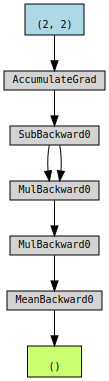

In [8]:
# visualize the computational graph with https://github.com/szagoruyko/pytorchviz
from torchviz import make_dot
make_dot(a)

In our case we had:

$x = \begin{bmatrix} 1 & 2 \\ 3 & 4  \end{bmatrix}$

$y = x - 2 = \begin{bmatrix} -1 & 0 \\ 1 & 2  \end{bmatrix}$

$z = y^2 * 3 = \begin{bmatrix} 1 & 0 \\ 1 & 4  \end{bmatrix} * 3 = \begin{bmatrix} 3 & 0 \\ 3 & 12  \end{bmatrix}$

$a = \bar{z} = \frac{3+0+3+12}{4} = 4.5$

so backpropagating, Mathematically we have:

$\frac{\partial{a}}{\partial{x_i}} = \frac{1}{4} \sum_j \frac{\partial{z_j}}{\partial{x_i}}$

$\frac{\partial{a}}{\partial{x_i}} = \frac{1}{4} \sum_j \frac{\partial{3y_j^2}}{\partial{x_i}}$

$\frac{\partial{a}}{\partial{x_i}} = \frac{1}{4} \sum_j 6y\frac{\partial{y_j}}{\partial{x_i}}$

$\frac{\partial{a}}{\partial{x_i}} = \frac{1}{4} \sum_j 6y\frac{\partial{(x_j-2)}}{\partial{x_i}} =  \frac{3}{2} \sum_j y\frac{\partial{(x_j-2)}}{\partial{x_i}} $

$\frac{\partial{a}}{\partial{x_i}} = \frac{3}{2} \sum_j (x_j-2)*1 = \frac{3}{2} (x_j-2)$

$\frac{\partial{a}}{\partial{x_i}} = \frac{3}{2} \begin{bmatrix} -1 & 0 \\ 1 & 2  \end{bmatrix} = \begin{bmatrix} -1.5 & 0 \\ 1.5 & 3  \end{bmatrix}$

Let's print gradients $\frac{\partial{a}}{\partial{x}}$

PLEASE NOTICE: `a=z.mean()` in this example is a scalar and we do not need to specify any parameters for backward. By default, we backpropagate a gradient of 1.0 back.

In [9]:
# backprop
a.backward()
print(x.grad)

tensor([[-1.5000,  0.0000],
        [ 1.5000,  3.0000]])


# Dynamic computational graph

In PyTorch, the variables and functions build a dynamic graph of computation. For every variable operation, it creates at least a single Function node that connects to functions that created a Variable. The attribute grad_fn of a variable references the function that creates the variable. x has no function but any variable created by an operation will have a function. (source: https://jhui.github.io/2018/02/09/PyTorch-Variables-functionals-and-Autograd/)

In [10]:
x = torch.randn(3, requires_grad=True)

y = x*2
i = 0
while y.data.norm() < 1000:
    y = y*2
    i += 1
    
print(x.grad_fn)     # None
print(y.grad_fn)     # The Function that create the Variable y
print(y)             # the variable

None
tensor([-1464.0775,   153.3061,   313.7990], grad_fn=<MulBackward0>)


### Backward (non-scalar output)

$y$ is a Tensor of size 3. backward requires a Tensor to specify each backpropagation gradient if the variable is not a scalar. To match each element of y, gradients needs to match the size of y. In some situtation, the gradient values are computed from the model predictions and the true labels.

In [11]:
# If we don't run backward on a scalar we need to specify the grad_output
gradients = torch.FloatTensor([0.1, 1.0, 0.0001])
y.backward(gradients)
print(x.grad)

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


## Example: inference

In [13]:
# this variable decide the tensor's range below
n = 3

In [19]:
# both inputs and weight w will allow gradient accumulation
x = torch.arange(1., n+1, requires_grad=True)
w = torch.ones(n, requires_grad=True)
z = w @ x # linear step
z.backward()
print(x.grad, w.grad, sep='\n')

tensor([1., 1., 1.])
tensor([1., 2., 3.])


In [16]:
# Only w that allows gradient accumulation
x = torch.arange(1., n+1, requires_grad=False)
w = torch.ones(n, requires_grad=True)
z = w @ x # linear step
z.backward()
print(x.grad, w.grad, sep='\n')

None
tensor([1., 2., 3.])


In [17]:
x = torch.arange(1., n + 1)
w = torch.ones(n, requires_grad=True)

# Regardless of what you do in this context, all torch tensors will not have gradient accumulation
with torch.no_grad():
    z = w @ x

try:
    z.backward()  # PyTorch will throw an error here, since z has no grad accum.
except RuntimeError as e:
    print('RuntimeError!!! >:[')
    print(e)

RuntimeError!!! >:[
element 0 of tensors does not require grad and does not have a grad_fn


## Example 2

In [45]:
dtype = torch.FloatTensor
N, D_in, H, D_out = 64, 1000, 100, 10

x = torch.randn((N, D_in), requires_grad=False) # torch.Size([64, 100])
y = torch.randn((N, D_out), requires_grad=False) # torch.Size([64, 10])

# accumulate gradient only for weights
w1 = torch.randn((D_in, H), requires_grad=True) #torch.Size([1000, 100])
w2 = torch.randn((H, D_out), requires_grad=True) #torch.Size([100, 10])

learning_rate = 1e-6
for t in range(500):
    y_pred = x.mm(w1).clamp(min=0).mm(w2) #torch.Size([64, 10])

    loss = (y_pred - y).pow(2).sum() # compute loss
    
    if (t % 100 == 0):
        print('t:{} - loss value: {}'.format(t, loss.data))

    loss.backward() # propagate loss backward

    w1.data -= learning_rate * w1.grad.data # update weights w1
    w2.data -= learning_rate * w2.grad.data # update weights w2

    w1.grad.data.zero_() # empty the w1 grad
    w2.grad.data.zero_() # empty the w2 grad

t:0 - loss value: 33153804.0
t:100 - loss value: 927.98876953125
t:200 - loss value: 10.574845314025879
t:300 - loss value: 0.20356957614421844
t:400 - loss value: 0.004852037876844406


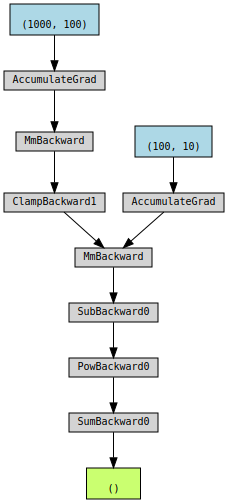

In [46]:
make_dot(loss)